<h1>Procesamiento de lenguaje natural aplicado al análisis de opinión política para las elecciones presidenciales en Colombia 2022<span class="tocSkip"></span></h1> 

>**Maestría en Analítica de Datos**  
>**Facultad de Ingeniería y Ciencias Básicas.**  
>**Universidad Central  2021 - III**  
>**Integrantes del trabajo:**  
>- Maria Alejandra Castillo Pabon
>- David Alejandro Ballesteros Díaz

# Librerias
Las librerías que se utilizan para la limpieza y transformación de los datos son:

In [1]:
#!pip install nltk
#!pip install wordcloud
import pandas as pd
import glob
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from spacy.lang.es import STOP_WORDS
import seaborn as sns
from scipy.spatial.distance import cosine

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malej\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Funciones personalizadas
Se crean las funciones personalizadas para la limpieza y transformación de los datos:

## Consolidar dataframe
Función que permite consolidar todos los archivos que contienen tweets de un candidato específico.

In [19]:
def consolidar(ruta,clave):
    df=pd.DataFrame()
    lista=[file_name for file_name in glob.glob(ruta+'/'+'*.csv') if file_name.find(clave) > 0]
    for archivo in lista:
        df0= pd.read_csv(archivo,index_col=False)
        df=pd.concat([df0, df])
    return(df)

## Tranformar texto de miles
Función que permite reemplazar las letras que representan el "mil" por los ceros correspondientes.

In [20]:
def valor_k(x):
    x=str(x)
    if x.find(".")>0 or x.find(",")>0:
        x=int(re.sub('[.,k,K,\s,a-zA-Z]','',x))*100
    elif x =='nan':
        x=0
    elif x.find("K") >0 or x.find("mil") >0:
        x=int(re.sub('[k,K\s,a-zA-Z]','',x))*1000
    else:
        x= int(x)
    return(x)

## Separar usuarios mencionados
Función que permite extraer los usuarios que son mencionados dentro del texto (por ejemplo @usuario) y lo almacena en una columna nueva.

In [21]:
def mencion(texto):
    nuevo_texto =str(texto)
    if nuevo_texto is None:
        pass
    else:
        try:
            nuevo_texto = texto.lower()
        except:
            pass
        regex = '@[a-z0-9\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\-\\/\\:\\;\\<\\=\\>\\?\\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\¡\\¿]+'
        nuevo_texto=re.findall(regex, nuevo_texto)
        return(nuevo_texto)

## Limpiar carateres especiales
Función que permite realizar la limpieza del texto.

In [22]:
def limpiar(texto):
    nuevo_texto =str(texto)
    if nuevo_texto is None:
        pass
    else:
        try:
            nuevo_texto = texto.lower()
        except:
            pass
        nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
        #regex = '@[a-z0-9\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\-\\/\\:\\;\\<\\=\\>\\?\\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\¡\\¿]+(\s)'
        regex = '@[a-z0-9\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\-\\/\\:\\;\\<\\=\\>\\?\\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\¡\\¿]+'
        nuevo_texto = re.sub(regex , ' ', nuevo_texto)
        regex = '[\\!\\"\\“\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\-\\/\\:\\;\\<\\=\\>\\?\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\¡\\¿\\.\\,\\·]'
        nuevo_texto = re.sub(regex , ' ', nuevo_texto)
        nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
        nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
        nuevo_texto=nuevo_texto.replace("replying to", "")
        nuevo_texto=nuevo_texto.replace("Replying to", "")
    return(nuevo_texto)

## Guardar Dataframe - CSV
Función que permite guardar el dataframe limpio en formato CSV.

In [23]:
def guardar_csv (df,nombre_archivo):
    df.to_csv(nombre_archivo+'.csv', index=False,encoding='utf-8')
    return('El archivo '+nombre_archivo+'.csv fue guardado exitosamente')

## Words Cloud
Función que permite generar una nube de las palabras que más se repiten en un texto determinado para posteriormente generar el gráfico "words cloud".

In [24]:
def lluvia(df,texto,lista):
    lista=lista
    stop_words = list(stopwords.words(['spanish','english']))
    stop_words.extend(("jul","agost","oct","jun","tweet","com","quote","cita","nov","aug","may","citar","q","ago","pm","Colombia","país","colombia","and",".",",","que","twitter","va","co","www","others","día"))
    stop_words.extend((lista))
    df=df.dropna()
    text = ' '.join(df) 
    wordcloud = WordCloud(width=1024, height=800, stopwords=stop_words, background_color="white", min_font_size=14).generate(text) 
    plt.figure(figsize= (8, 8), facecolor=None)
    plt.suptitle(texto,size=20) 
    plt.imshow(wordcloud)
    plt.axis('off') 
    plt.tight_layout(pad = 0) 
    return (plt.show())

## Lematización de Texto

Función que permite identificar el lema o raíz de de una palabra.

In [25]:
def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

# Limpieza y Consolidación

## Consolidación Entorno
Teniendo en cuenta que la extacción de los datos se generó más de un archivo con la información de un candidato, se hace necesario consolidar ésta información en un solo dataframe. Como resultado de éste proceso, se generarán 5 dataframe, uno por cada candidato (Óscar Ivan Zuliaga, María Fernanda Cabal, Rodolfo Hernandéz, Gustavo Petro y Sergio Fajardo) 

In [26]:
usuarios=("OIZuluaga","MariaFdaCabal","ingrodolfohdez","petrogustavo","sergio_fajardo")
ruta='C:\\Users\David\Python\PNL\Entorno'
df=pd.DataFrame()
for usuario in usuarios:
    df0=consolidar(ruta,usuario)
    df0['usuario']=usuario
    df=pd.concat([df0, df])
df=df.drop_duplicates(['id', 'nombre','usuario'], keep='last')
df0 = df['id'].value_counts()
df0=pd.DataFrame(df0, columns=['id','conteo']).reset_index()
df0.drop(columns="conteo", inplace=True)
df0=df0.rename(columns={"index": "id", "id": "conteo"})
df1 = df.merge(df0, left_on="id", right_on="id", how='left')
df2= pd.read_csv(ruta +"\clasificacion_usuarios.csv" ,index_col=False,encoding='latin')
df1= df1.merge(df2[["id","grupo"]], left_on="id", right_on="id", how='left')
guardar_csv(df1,"entorno_consolidado")

KeyError: 'id'

## Limpieza Tweets
Se realiza la limpieza del texto para cada uno de los dataframe generados en el paso anterior y posteriormente se generan 5 nuevos dataframe.

In [27]:
usuarios=("ingrodolfohdez","OIZuluaga","MariaFdaCabal","petrogustavo","sergio_fajardo")
ruta='C:\\Users\malej\Documents\GitHub\ProyectoGrado\datos\datos_sin_procesar\candidatotweet'
for usuario in usuarios:
    df=consolidar(ruta,usuario)
    df['cantidad_comentarios']=df['cantidad_comentarios'].apply(valor_k)
    df['cantidad_likes']=df['cantidad_likes'].apply(valor_k)
    df['Cantidad_Retweets']=df['Cantidad_Retweets'].apply(valor_k)
    df['mencion']=df['texto'].apply(mencion)
    df['texto']=df['texto'].apply(limpiar)
    locals()["df_tweets_consolidado_"+usuario] = df
    guardar_csv (df,"df_tweets_consolidado_"+usuario)
    

## Carga de Archivos

In [29]:
dfzuluaga= pd.read_csv('df_tweets_consolidado_OIZuluaga.csv')
dfpetro= pd.read_csv('df_tweets_consolidado_petrogustavo.csv')
dfsergio= pd.read_csv('df_tweets_consolidado_sergio_fajardo.csv')
dfcabal= pd.read_csv('df_tweets_consolidado_MariaFdaCabal.csv')
dfrodolfo= pd.read_csv('df_tweets_consolidado_ingrodolfohdez.csv')

## Nube de Palabras
Se crea una nube de palabras más utilizadas en los tweets generados por cada candidato. Se decide eliminar en cada nube el nombre del candidato objeto de análisis. 

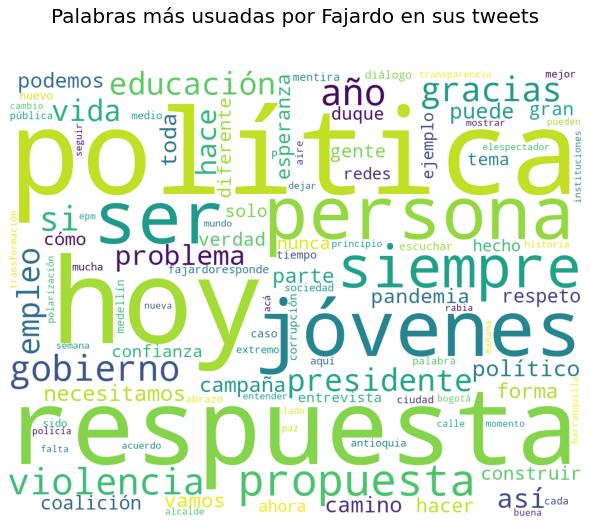

None


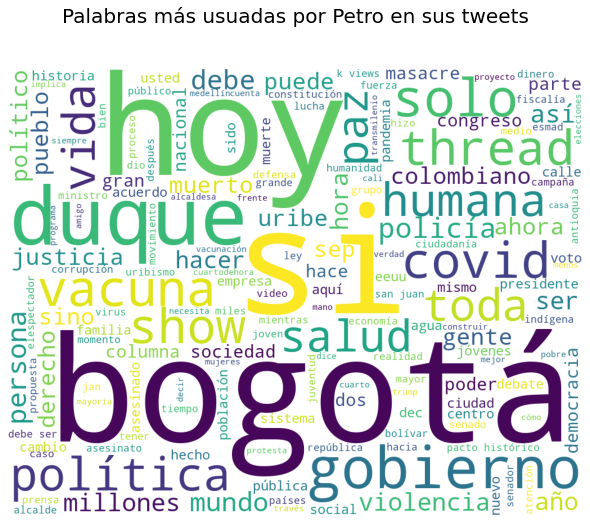

None


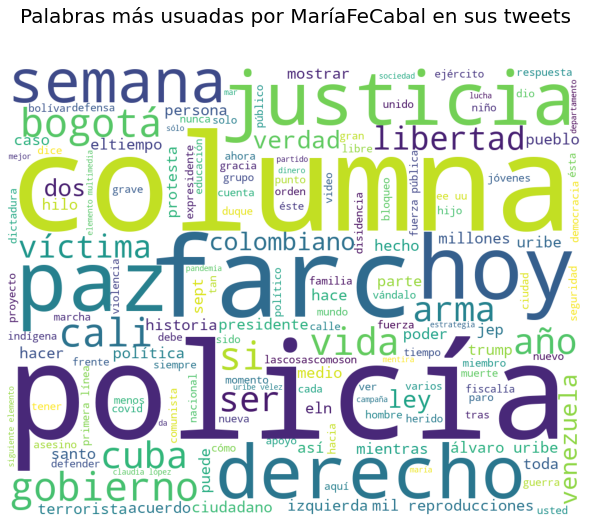

None


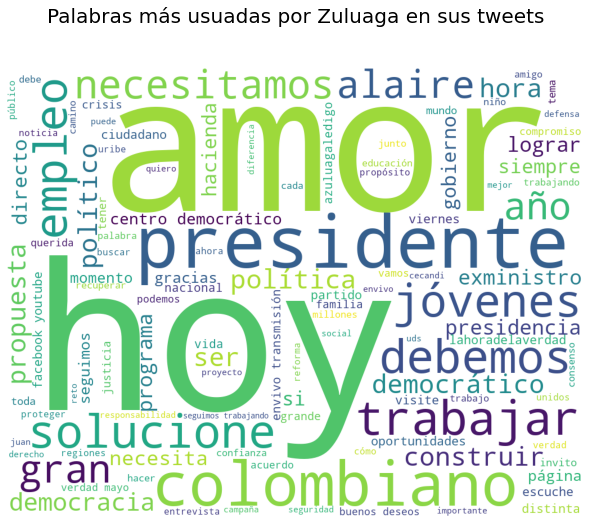

None


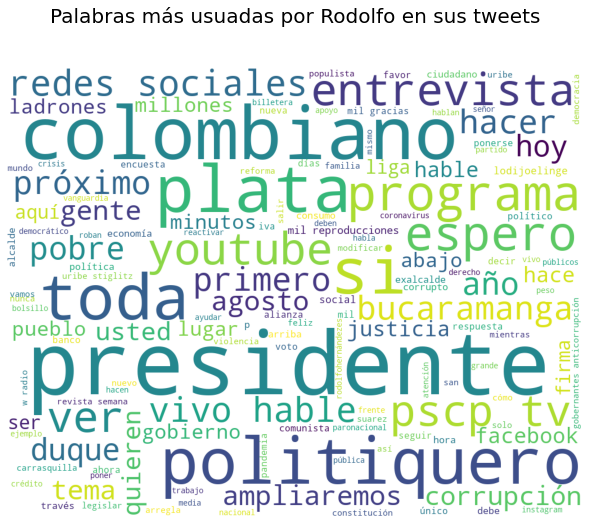

None


In [30]:
lista= ["sergio", "fajardo", "sergio fajardo","sergiofajardo","petro","gustavo petro","gustavo","cabal","maria fernanda","mariafernandacabal","maria","fernanda","zuluaga","iván zuluaga","óscar iván","ingrorodolfo","ingeniero","ing","rodolfo hernández", "rodolfo","hernández","hernandez","ingrodolfohdez","ingrodolfo","lunes","sr","vez","óscar","iván"]
print(lluvia(dfsergio['texto'],'Palabras más usuadas por Fajardo en sus tweets',lista))
print(lluvia(dfpetro['texto'],'Palabras más usuadas por Petro en sus tweets',lista))
print(lluvia(dfcabal['texto'],'Palabras más usuadas por MaríaFeCabal en sus tweets',lista))
print(lluvia(dfzuluaga['texto'],'Palabras más usuadas por Zuluaga en sus tweets',lista))
print(lluvia(dfrodolfo['texto'],'Palabras más usuadas por Rodolfo en sus tweets',lista))

# Análisis Exploratorio

Para el análisis explotario se realiza el cargue del modelo en español "es_core_news_md" de la librería de spacy, con el fin de poder tokenizar el texto y relizar un conteo de palabras e identificación de palabras más usados en los discursos de cada candidato.

In [42]:
nlp = spacy.load("es_core_news_md")

## Cargue de Dataframe

Se realiza el cargue de los dataframe que contienen los tweets escritos por los candidatos, los datos de estos dataframe ya han sido previamente limpiados. Adicionalmente, se eliminan los registros que contienen datos nulos ya que no aportan información relevante para el estudio. 

In [43]:
dfzuluaga= pd.read_csv('df_tweets_consolidado_OIZuluaga.csv')
dfzuluaga=dfzuluaga[dfzuluaga['nombre']== 'Óscar Iván Zuluaga']
dfzuluaga = dfzuluaga[dfzuluaga['texto'].notna()]
dfpetro= pd.read_csv('df_tweets_consolidado_petrogustavo.csv')
dfpetro = dfpetro[dfpetro['texto'].notna()]
dfsergio= pd.read_csv('df_tweets_consolidado_sergio_fajardo.csv')
dfsergio = dfsergio[dfsergio['texto'].notna()]
dfcabal= pd.read_csv('df_tweets_consolidado_MariaFdaCabal.csv')
dfcabal = dfcabal[dfcabal['texto'].notna()]
dfrodolfo= pd.read_csv('df_tweets_consolidado_ingrodolfohdez.csv')
dfrodolfo = dfrodolfo[dfrodolfo['texto'].notna()]

## Conteo de Tweets por cada candidato
print('Número de tweets Óscar Iván Zuluaga: ' + str(dfzuluaga.shape[0]))
print('Número de tweets Gustavo Petro: ' + str(dfpetro.shape[0]))
print('Número de tweets Sergio Fajardo: ' + str(dfsergio.shape[0]))
print('Número de tweets Maria Fernanda Cabal: ' + str(dfcabal.shape[0]))
print('Número de tweets Rodolfo Hernández: ' + str(dfrodolfo.shape[0]))

Número de tweets Óscar Iván Zuluaga: 407
Número de tweets Gustavo Petro: 2965
Número de tweets Sergio Fajardo: 612
Número de tweets Maria Fernanda Cabal: 1353
Número de tweets Rodolfo Hernández: 308


## Tokenización y Lematización de Texto

Se tokeniza el texto de los tweets generados por los candidatos, con el fin de dividir el texto en palabras, por otra parte se lematiza el texto para identificar la forma y lema de las palabra. Tanto el token como el lematizado, se guardan en variables independientes.

In [44]:
dfzuluaga['texto_tokenizado'] =dfzuluaga['texto'].apply(lambda x: nlp(x))
dfzuluaga['lematizado'] = dfzuluaga['texto'].apply(lambda x: lemmatizer(x))

dfpetro['texto_tokenizado'] =dfpetro['texto'].apply(lambda x: nlp(x))
dfpetro['lematizado'] = dfpetro['texto'].apply(lambda x: lemmatizer(x))

dfsergio['texto_tokenizado'] =dfsergio['texto'].apply(lambda x: nlp(x))
dfsergio['lematizado'] = dfsergio['texto'].apply(lambda x: lemmatizer(x))

dfcabal['texto_tokenizado'] =dfcabal['texto'].apply(lambda x: nlp(x))
dfcabal['lematizado'] = dfcabal['texto'].apply(lambda x: lemmatizer(x))

dfrodolfo['texto_tokenizado'] =dfrodolfo['texto'].apply(lambda x: nlp(x))
dfrodolfo['lematizado'] = dfrodolfo['texto'].apply(lambda x: lemmatizer(x))

## Nube de Palabras (texto lematizado)

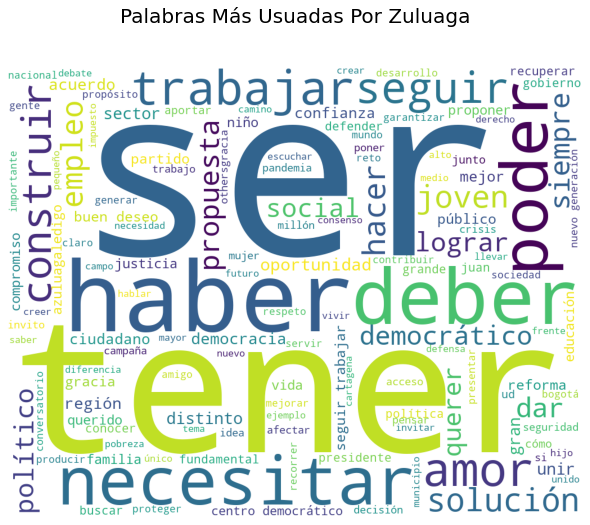

None


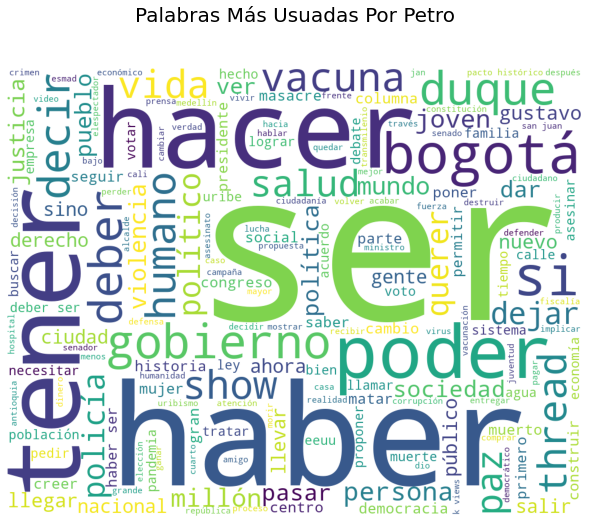

None


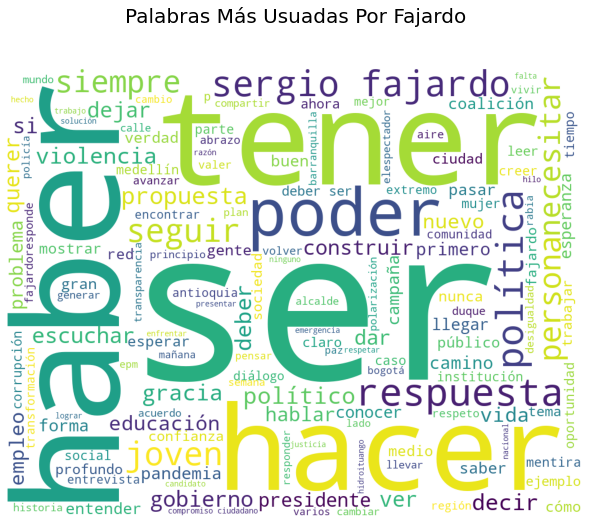

None


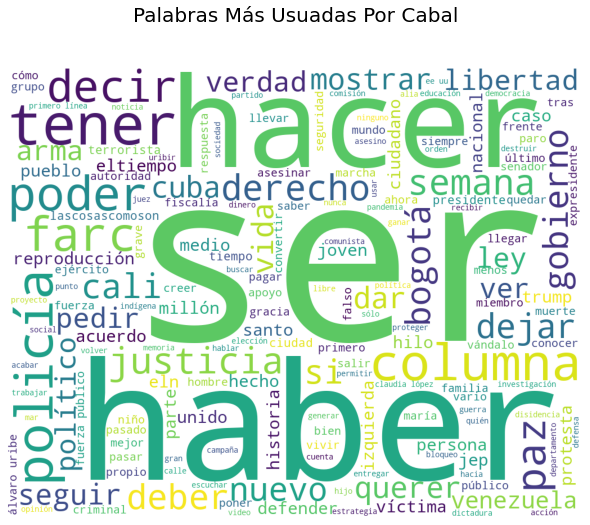

None


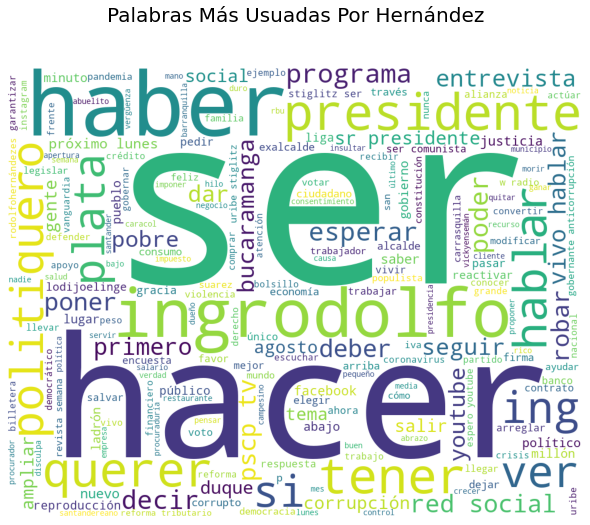

None


In [45]:
lista= ["hoy","others","twitter","sep","dec","vez","covid","petro","colombiano","colombia","señor","año","hora","mismo","ir","así","día","cada","dos","hacía","aquí","palabra","acá","algúno","sergio fajardo","fajardorespondir","fernanda cabal","solo","momento","mariafernandacabal","co","maria fernanda","fernanda cabal","fernanda","cabal","maria","mil","alguno","usted","sept","ingeniero","rodolfo hernández","mientras","tra","rodolfo hernández","rodolfo","hernández","hernandez"]
print(lluvia(dfzuluaga['lematizado'],'Palabras Más Usuadas Por Zuluaga',lista))
print(lluvia(dfpetro['lematizado'],'Palabras Más Usuadas Por Petro',lista))
print(lluvia(dfsergio['lematizado'],'Palabras Más Usuadas Por Fajardo',lista))
print(lluvia(dfcabal['lematizado'],'Palabras Más Usuadas Por Cabal',lista))
print(lluvia(dfrodolfo['lematizado'],'Palabras Más Usuadas Por Hernández',lista))

## Eliminación Stop Words

Se cargan las stop words en español que se encuentran definidas en la libreria de Spacy y se eliminan del texto tokenizado. Éstas palabras se eliminan ya que no aportan importancia para el análisis.  

In [189]:
tweetscandidatos = pd.concat([dfzuluaga, dfpetro, dfsergio,dfcabal,dfrodolfo]).reset_index(drop=True)
tweetscandidatos = tweetscandidatos.drop(['texto','emoticon','link','fecha'], axis=1)

In [190]:
stopwords = nlp.Defaults.stop_words
nlp.Defaults.stop_words |= {"colombia","que","a",".",",","y","·","...","“","com","”"," ","","hoy","others","twitter","sep","dec","vez","covid","petro","colombiano","colombia","señor","año","hora","mismo","ir","así","día","cada","dos","hacía","aquí","palabra","acá","algúno","sergio fajardo","fajardorespondir","fernanda cabal","solo","momento","mariafernandacabal","co","maria fernanda","fernanda cabal","fernanda","cabal","maria","mil","alguno","usted","sept","ingeniero","rodolfo hernández","mientras","tra","rodolfo hernández","rodolfo","hernández","hernandez","q","tweet","quote","ingrodolfo","sergio","fajardo","and","jul","país","citar","duque","may","this","presidente","bogotá","ing","@"}
tweetscandidatos['token_stopword']=tweetscandidatos['texto_tokenizado'].apply(lambda x: [str(w) for w in x if not w.text in stopwords])
tweetscandidatos = tweetscandidatos.explode(column='token_stopword')

In [77]:
#guardar_csv (tweetscandidatos,"dfcandidatosconsolidado")
#tweetscandidatos= pd.read_csv('dfcandidatosconsolidado.csv')

## Palabras totales por candidato

In [104]:
tweetscandidatos.groupby('nombre')['token_stopword'].count()

nombre
Gustavo Petro              72959
Ing Rodolfo Hernandez !     3245
María Fernanda Cabal       26947
Sergio Fajardo             10637
Óscar Iván Zuluaga          3587
Name: token_stopword, dtype: int64

## Palabras distintas por candidato

In [105]:
tweetscandidatos.groupby('nombre')['token_stopword'].nunique()

nombre
Gustavo Petro              17034
Ing Rodolfo Hernandez !     1633
María Fernanda Cabal        9116
Sergio Fajardo              4521
Óscar Iván Zuluaga          1773
Name: token_stopword, dtype: int64

## Top 5 palabras más usadas por candidato

In [83]:
tweetscandidatos.groupby(['nombre','token_stopword'])['token_stopword'] \
 .count() \
 .reset_index(name='count') \
 .groupby('nombre') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

nombre token_stopword  count
nombre                                                                      
Gustavo Petro           7565             Gustavo Petro       gobierno    358
                        8073             Gustavo Petro         humana    257
                        14433            Gustavo Petro          salud    246
                        14771            Gustavo Petro           show    245
                        12413            Gustavo Petro       política    243
Ing Rodolfo Hernandez ! 17772  Ing Rodolfo Hernandez !          hable     30
                        17308  Ing Rodolfo Hernandez !    colombianos     29
                        18194  Ing Rodolfo Hernandez !          plata     26
                        17640  Ing Rodolfo Hernandez !         espero     25
                        18211  Ing Rodolfo Hernandez !   politiqueros     24
María Fernanda Cabal    20252     María Fernanda Cabal        columna    152
                        27284     María Fernanda Cabal          uribe    112
                        22208     María Fernanda Cabal           farc    112
                        26495     María Fernanda Cabal         semana    108
                        23501     María Fernanda Cabal       justicia     93
Sergio Fajardo          31028           Sergio Fajardo       política     95
                        31488           Sergio Fajardo      respuesta     83
                        30211           Sergio Fajardo        jóvenes     60
                        29773           Sergio Fajardo       gobierno     49
                        29785           Sergio Fajardo        gracias     45
Óscar Iván Zuluaga      32394       Óscar Iván Zuluaga           amor     35
                        33838       Óscar Iván Zuluaga       seguimos     29
                        32821       Óscar Iván Zuluaga    democrático     25
                        33883       Óscar Iván Zuluaga     soluciones     24
                        33281       Óscar Iván Zuluaga        jóvenes     24

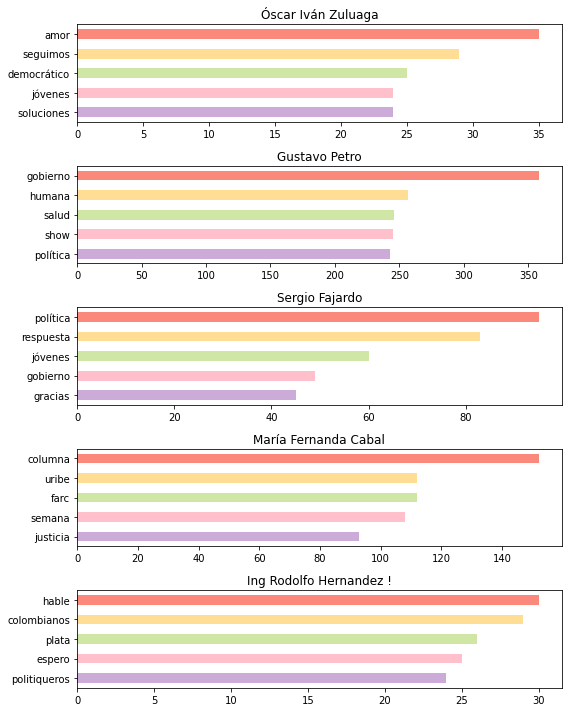

In [103]:
fig, axs = plt.subplots(nrows=5, ncols=1,figsize=(8, 10))
for i, nombre in enumerate(tweetscandidatos.nombre.unique()):
    df_temp = tweetscandidatos[tweetscandidatos.nombre == nombre]
    counts  = df_temp['token_stopword'].value_counts(ascending=False).head(5)
    counts.plot(kind='barh', color=[ "#FA897B", "#FFDD94", "#D0E6A5","pink","#CCABD8" ], ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(nombre)

fig.tight_layout()

## Correlación entre los candidatos
Se crea una matriz de correlación para identificar la similitud entre los perfiles de los candidatos, de acuerdo a las palabras que escriben. Para ésto se realiza una tabla pivóte con el fin de crear una columna para cada candidato; luego se crea una función para el cálculo de la similitud entre las palabras haciendo uso de la función coseno.  

In [191]:
tweetspivot = tweetscandidatos.groupby(["nombre","token_stopword"])["token_stopword"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token_stopword" , columns="nombre", values= "count")
tweetspivot.columns.name = None

In [192]:
def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia
dfcorrelacion=tweetspivot.corr(method=similitud_coseno)
dfcorrelacion

,Gustavo Petro,Ing Rodolfo Hernandez !,María Fernanda Cabal,Sergio Fajardo,Óscar Iván Zuluaga
Gustavo Petro,1.000000,0.482644,0.712359,0.647362,0.523762
Ing Rodolfo Hernandez !,0.482644,1.000000,0.530673,0.506557,0.486038
María Fernanda Cabal,0.712359,0.530673,1.000000,0.585066,0.499145
Sergio Fajardo,0.647362,0.506557,0.585066,1.000000,0.595970
Óscar Iván Zuluaga,0.523762,0.486038,0.499145,0.595970,1.000000


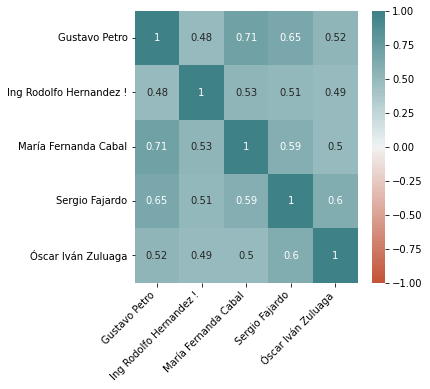

In [193]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.heatmap(dfcorrelacion,annot= True,vmin= -1,vmax = 1, center = 0, cmap= sns.diverging_palette(20, 200, n=100), ax = ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45,horizontalalignment = 'right')
ax.tick_params(labelsize = 10)

## Palabras comunes entre candidatos

In [206]:
petro = set(tweetscandidatos[tweetscandidatos.nombre == 'Gustavo Petro']['token_stopword'])
cabal = set(tweetscandidatos[tweetscandidatos.nombre == 'María Fernanda Cabal']['token_stopword'])
fajardo = set(tweetscandidatos[tweetscandidatos.nombre == 'Sergio Fajardo']['token_stopword'])
cabal = set(tweetscandidatos[tweetscandidatos.nombre == 'María Fernanda Cabal']['token_stopword'])
hernandez = set(tweetscandidatos[tweetscandidatos.nombre == 'Ing Rodolfo Hernandez !']['token_stopword'])
zuluaga = set(tweetscandidatos[tweetscandidatos.nombre == 'Óscar Iván Zuluaga']['token_stopword'])

print(f"Palabras comunes entre Gustavo Petro y Ma Fernanda Cabal:  {len(petro.intersection(cabal))}")
print(f"Palabras comunes entre Gustavo Petro y Sergio Fajardo:     {len(petro.intersection(fajardo))}")
print(f"Palabras comunes entre Sergio Fajardo y Ma Fernanda Cabal: {len(fajardo.intersection(cabal))}")
print(f"Palabras comunes entre óscar Zuluaga y Gustavo Petro:      {len(zuluaga.intersection(petro))}")
print(f"Palabras comunes entre Sergio Fajardo y óscar Zuluaga:     {len(fajardo.intersection(zuluaga))}")
print(f"Palabras comunes entre óscar Zuluaga y Rodolfo Hernández:  {len(zuluaga.intersection(hernandez))}")

Palabras comunes entre Gustavo Petro y Ma Fernanda Cabal:  5152
Palabras comunes entre Gustavo Petro y Sergio Fajardo:     2991
Palabras comunes entre Sergio Fajardo y Ma Fernanda Cabal: 2226
Palabras comunes entre óscar Zuluaga y Gustavo Petro:      1301
Palabras comunes entre Sergio Fajardo y óscar Zuluaga:     859
Palabras comunes entre óscar Zuluaga y Rodolfo Hernández:  426
